<h1 style="margin: auto; padding: 20px 0; text-align: center">PROJET 10 DATA ANALYST</h1>
<h2 style="margin: auto; padding: 20px 0; text-align: center">Détectez des faux billets</h2>

In [1]:
# Importer les librairies
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as st
from scipy.stats import t, shapiro

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_white , normal_ad
from statsmodels.api import Logit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import cluster
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , roc_curve, accuracy_score , precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [2]:
# Importer le fichier
billets = pd.read_csv('billets.csv', sep=';')
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


On a actuellement de six informations géométriques sur un billet :

- diagonal : la diagonale du billet (en mm);
- height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;
- length : la longueur du billet (en mm).

In [3]:
# Info sur le type et nom de chaque colonne
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [4]:
# Description chiffrées des données
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [5]:
# Identifier valeurs nulles
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [6]:
# Détails True/False de chaque colonne
billets.groupby('is_genuine').count()

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,500,500,500,492,500,500
True,1000,1000,1000,971,1000,1000


<Axes: xlabel='length', ylabel='is_genuine'>

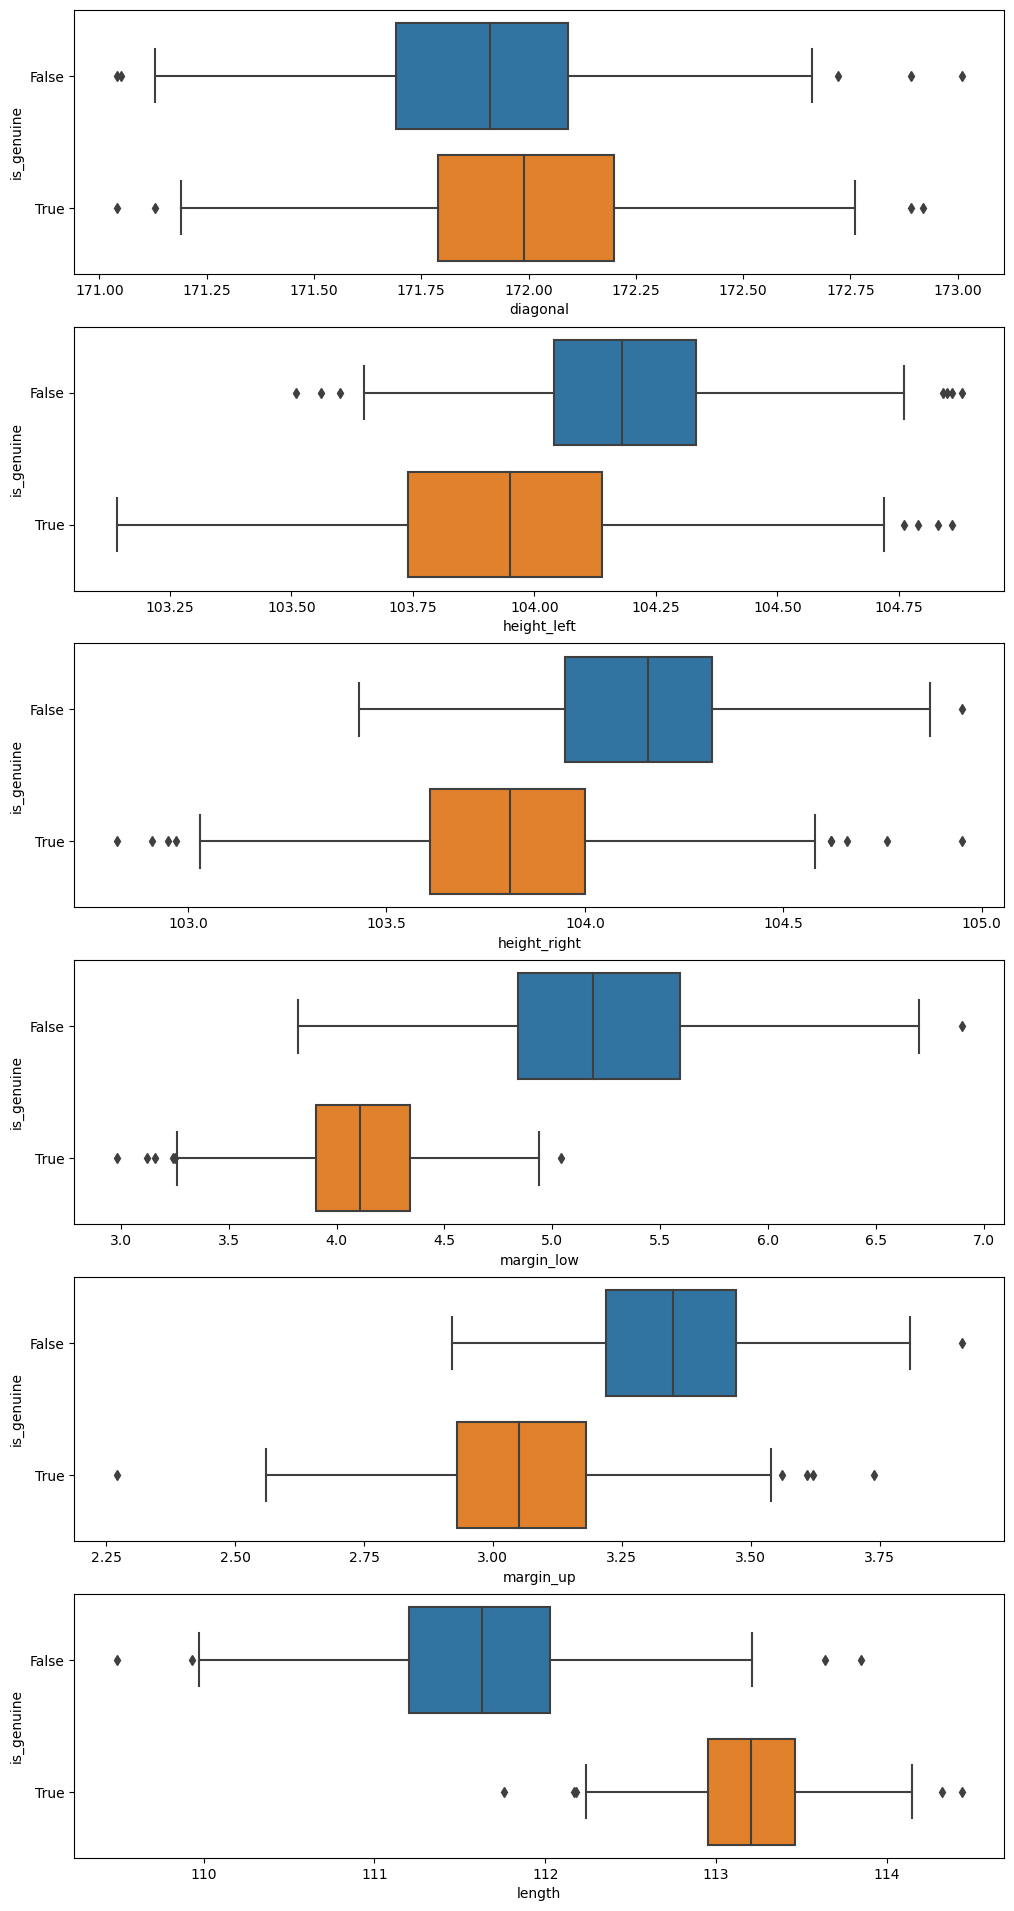

In [7]:
# Dispersion des variables en fonction de True/False
fig, axs = plt.subplots(6,1, figsize=(12,24))
sns.boxplot(billets, ax=axs[0], orient="h", x='diagonal',y='is_genuine')
sns.boxplot(billets, ax=axs[1], orient="h", x='height_left',y='is_genuine' )
sns.boxplot(billets, ax=axs[2], orient="h", x='height_right',y='is_genuine')
sns.boxplot(billets, ax=axs[3], orient="h", x='margin_low',y='is_genuine')
sns.boxplot(billets, ax=axs[4], orient="h", x='margin_up',y='is_genuine')
sns.boxplot(billets, ax=axs[5], orient="h", x='length',y='is_genuine')

In [8]:
# Remplacer True/False par 1,0 (True=1 , False=0)
billets['is_genuine'].replace([True,False],[1,0], inplace=True)

In [9]:
# Dataframe avec uniquements les valeurs manquantes (37 lignes)
billets_mqt = billets.loc[billets['margin_low'].isna(), ['is_genuine','diagonal','height_left','height_right','margin_up','length']]
billets_mqt.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36


In [10]:
# Dataframe sans les valeurs manquantes (1463 lignes)
billets1 = billets.dropna()
billets1.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


<h3> Régression linéaire multiple </h3>

Pour remplacer les valeurs manquantes de la colonne "margin_low", on va utiliser la Régression Linéaire Multiple. Pour ce faire, on va créer un modèle à partir de toutes les variable.

In [11]:
reg_multi = smf.ols('margin_low~length+height_left+height_right+margin_up+diagonal', data=billets).fit()
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 15 Mar 2024   Prob (F-statistic):          2.60e-202
Time:                        10:22:08   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382      0.017       4.055      41.935
length          -0.4091      0.018    -22.627      0.000      -0.445      -0.374
height_left      0.1841      0.045      4.113      0.000       0.096       0.272
height_right     0.2571      0.043      5.978      0.000       0.173       0.342
margin_up        0.2562      0.064      3.980      0.000       0.130       0.382
diagonal        -0.1111      0.041     -2.680      0.007      -0.192      -0.030
==============================================================================
Omnibus:                       73.627   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.862
Skew:                           0.482   Prob(JB):                     1.53e-21
Kurtosis:                       3.801   Cond. No.                     1.94e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Si le R² vaut 1, alors toutes les variables sont expliquées par le modèle.
- Si le R² vaut 0, alors aucune variable n'est expliquée par le modèle.

Ici, le coefficient de détermination R-Squared est de 0,47, près de la moitié de la variation observée dans le modèle calculé peut être expliquée.

<h4>Vérifier la colinéarité des variables</h4>

In [12]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5769501453665857,
 1.1382605736082507,
 1.2301145155560393,
 1.4044037781843624,
 1.0136128990686288]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

<h4>Tester l'homoscédasticité</h4>

Pour tester la constance de la variance des résidus( homoscédasticité), on considère :

    - H0 : homoscédasticité des résidus
    - H1 : hétéroscédasticité des résidus

In [13]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 7.759535216207035e-16


p-value < 5% donc l'hypothèse H0 est vérifiée. Il y a homoscédasticité des résidus.

<h4>Test de Shapiro</h4>

Test pour évaluer la normalité de la distribution. 
- Hypothèse nulle : normalement distribué

In [14]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9857882857322693, pvalue=8.540482210328548e-11)

p-value < 5% donc l'hypothèse nulle de normalité est rejetée

<h3> Appliquer notre modèle </h3>

In [15]:
a_prevoir = billets_mqt.copy()
a_prevoir.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36


In [16]:
# on prédit
prevu = reg_multi.predict(a_prevoir)
billets_mqt['margin_low_pred'] = prevu
billets_mqt.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low_pred
72,1,171.94,103.89,103.45,3.25,112.79,4.318525
99,1,171.93,104.07,104.18,3.14,113.08,4.393668
151,1,172.07,103.80,104.38,3.02,112.93,4.410457
197,1,171.45,103.66,103.80,3.62,113.27,4.319014
241,1,171.83,104.14,104.06,3.02,112.36,4.650617


In [17]:
billets_final = billets.copy()
billets_final.loc[billets_mqt.index, 'margin_low'] = billets_mqt['margin_low_pred']
billets_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [18]:
billets_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [19]:
billets_final.shape

(1500, 7)

<h3> Régression Logistique </h3>

In [20]:
# Dataframe après régression linéaire : info et describe
billets_final.info()
billets_final.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.483475,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659632,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


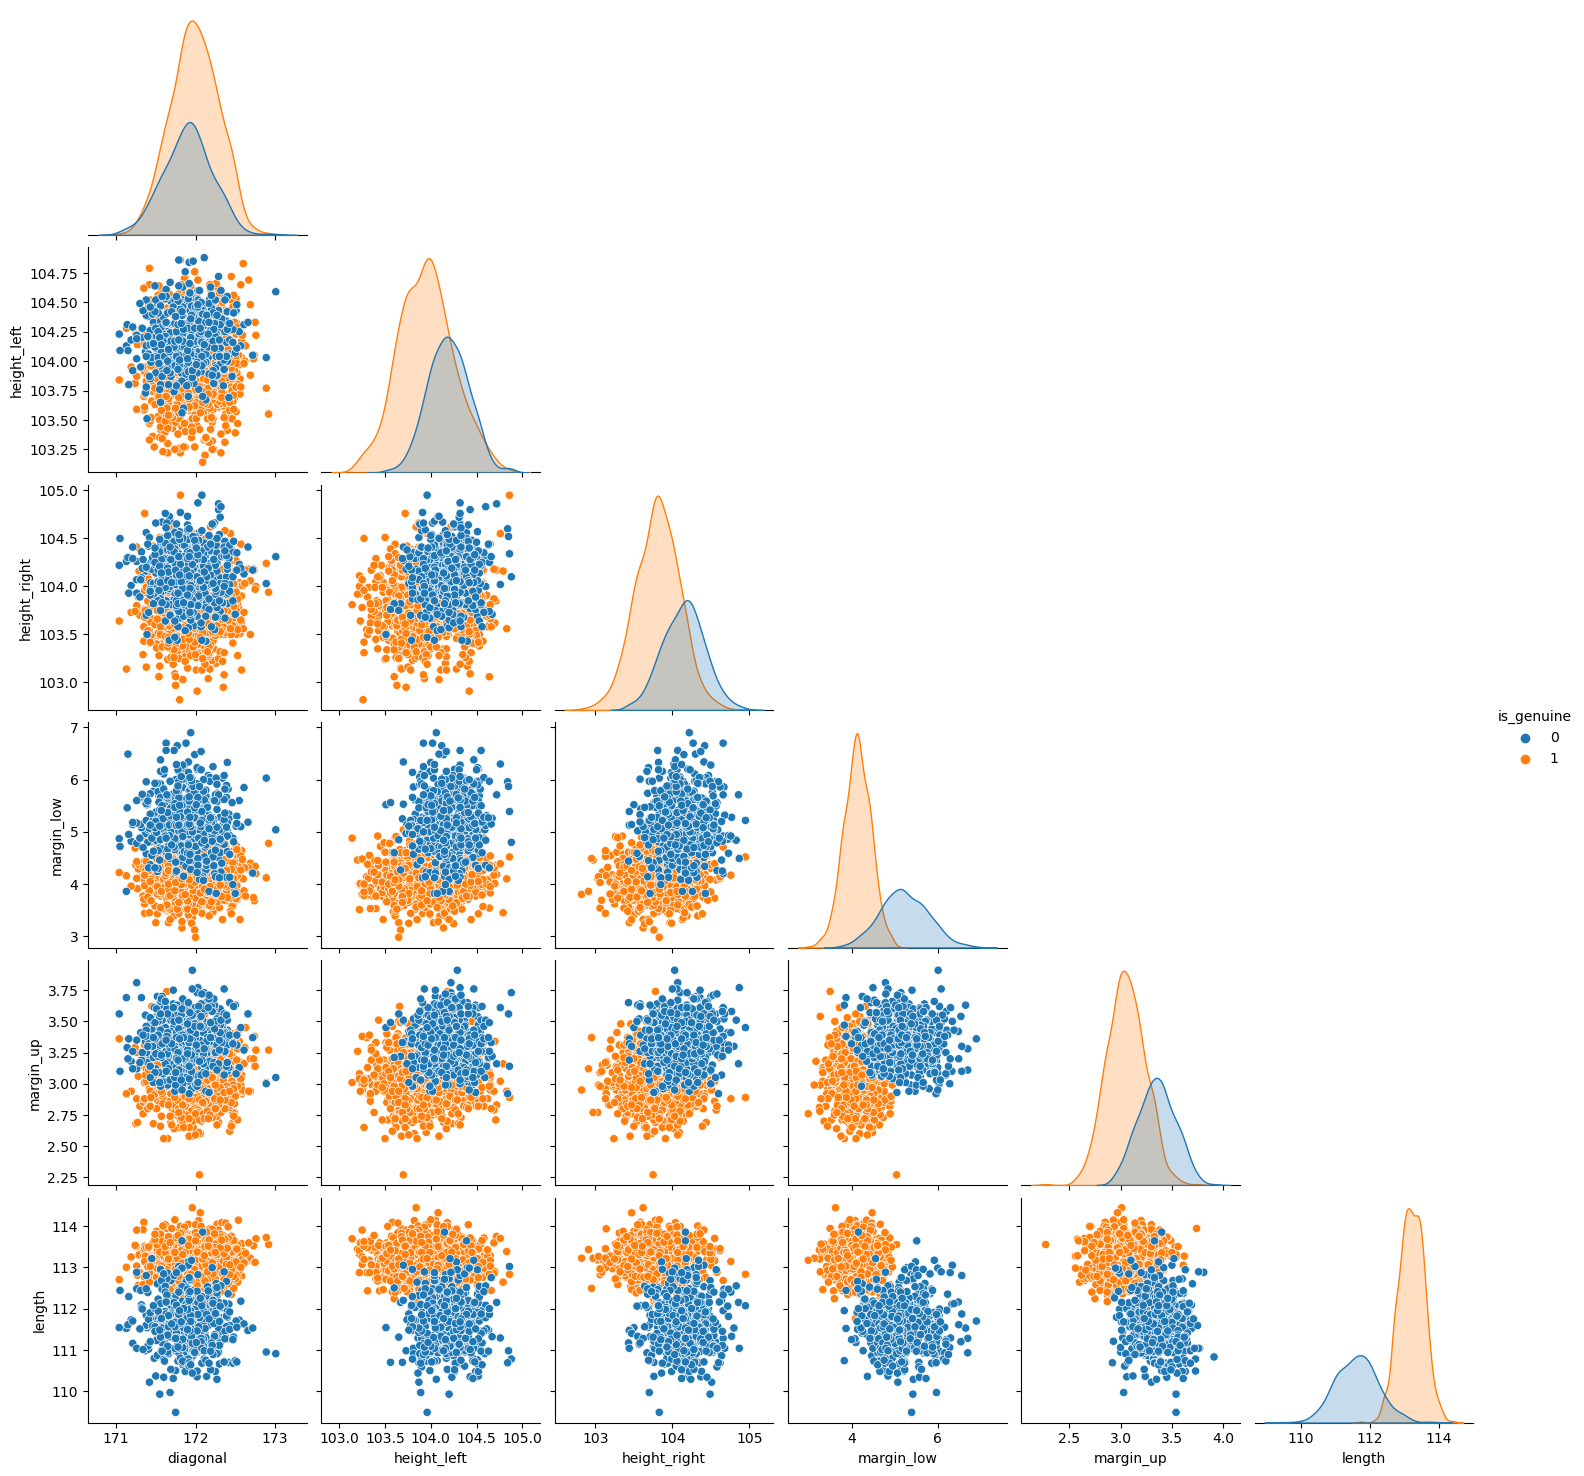

In [21]:
# Visualisation des données
sns.pairplot(billets_final, hue='is_genuine', corner=True)

On constate que les variables qui différencient le mieux les valeurs True et False sont :

    - margin_low
    - length

In [22]:
X = billets_final[['diagonal','height_left','height_right','margin_low','margin_up','length']]  # variables explicatives
y = billets_final.is_genuine  # variable à expliquer

In [23]:
X.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [24]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: is_genuine, dtype: int64

In [25]:
# Séparer le jeu de données en un jeu d'entraînement et un jeu de test
# Jeu de test contient 30% des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1050, 6)

(450, 6)

(1050,)

(450,)

In [26]:
# Construction modèle
estim = LogisticRegression()
estim.fit(X_train, y_train)

LogisticRegression()

In [27]:
y_train

485     1
527     1
199     1
889     1
844     1
       ..
1130    0
1294    0
860     1
1459    0
1126    0
Name: is_genuine, Length: 1050, dtype: int64

In [28]:
y_pred = estim.predict(X_test)  # prédiction

In [29]:
y_prob = estim.predict_proba(X_test).round(2)
y_prob

array([[1.  , 0.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.98, 0.02],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.98, 0.02],
       [0.01, 0.99],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.96, 0.04],
       [0.15, 0.85],
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.49, 0.51],
       [1.  , 0.  ],
       [0.99, 0.01],
       [0.59, 0.41],
       [0.99, 0.01],
       [0.05, 0.95],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.03, 0.97],
       [0.03, 0.97],
       [0.98, 0.02],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.98, 0.02],
       [0.01, 0.99],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.01, 0.99],
       [0.01,

In [30]:
# Accuracy score
def score(estim):
    """compute and print train score and test score"""
    tr_score = estim.score(X_train, y_train).round(4)
    te_score = estim.score(X_test,y_test).round(4)
    print(f"score train: {tr_score} score test: {te_score}")

In [31]:
score(estim)

score train: 0.9895 score test: 0.9867


In [32]:
te_score = estim.score(X_test,y_test).round(4)
te_score

0.9867

In [33]:
# On vérifie le score de notre model sur les données Test (F1 score)
score_f1 = f1_score(y_test, y_pred)
score_f1 = round(score_f1*100,4)
print("Le score de notre model sur les données Test est de :", score_f1,"%")

Le score de notre model sur les données Test est de : 98.9691 %


In [34]:
# Matrice de confusion
def confusion(y_test,y_pred):
    """display a fancy confusion matric"""
    mat = confusion_matrix(y_test,y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    
    return mat

In [35]:
mc = confusion(y_test,y_pred)
mc

,pred_0,pred_1
test_0,156,5
test_1,1,288


Text(0.5, 1.0, 'Matrice de confusion de la régression logistique')

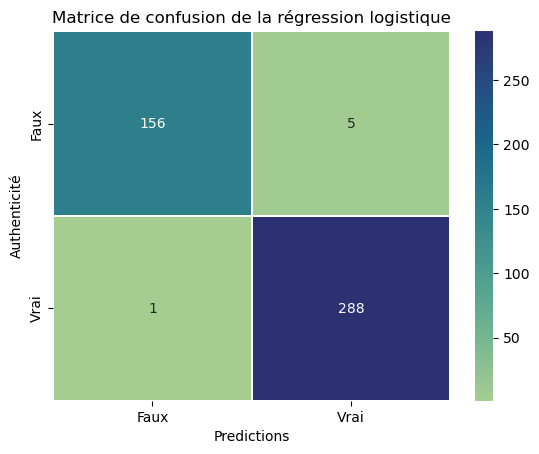

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt=".3g", cmap=sns.color_palette("crest", as_cmap=True),
           linecolor='white', linewidths=0.3,
            xticklabels=["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
           )
plt.xlabel("Predictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion de la régression logistique")

In [37]:
# Composition de la matrice de confusion
vrai_pos = cm[1][1]
vrai_neg = cm[0][0]
faux_pos = cm[1][0]
faux_neg = cm[0][1]
vrai_pos, vrai_neg, faux_pos, faux_neg

(288, 156, 1, 5)

In [38]:
# Sensibilité de la regression logistique
sensi = vrai_pos/((vrai_pos)+faux_neg)
sensi

0.9829351535836177

In [39]:
# Spécificité de la régression logistique 
speci = vrai_neg / (vrai_neg + faux_pos)
speci

0.9936305732484076

In [40]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.9827419458832126


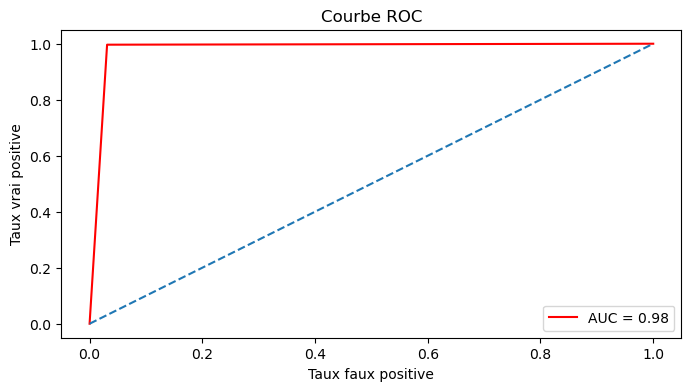

In [41]:
#Courbe Receiver Operating Characteristic (Area Under the roC) (fonction d'efficacité du recepteur)
plt.figure(figsize=(8,4))
plt.title('Courbe ROC')
plt.plot(false_positive_rate, true_positive_rate, color='red', label= 'AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--')
plt.axis('tight')
plt.ylabel('Taux vrai positive')
plt.xlabel('Taux faux positive')
plt.show()

<h3> Algorithme K-Means </h3>

In [74]:
dt_kmeans = billets_final.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
dt_kmeans.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [75]:
y_true = billets_final['is_genuine']
y_true

0       1
1       1
2       1
3       1
4       1
       ..
1495    0
1496    0
1497    0
1498    0
1499    0
Name: is_genuine, Length: 1500, dtype: int64

In [76]:
X = dt_kmeans.values
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\clust

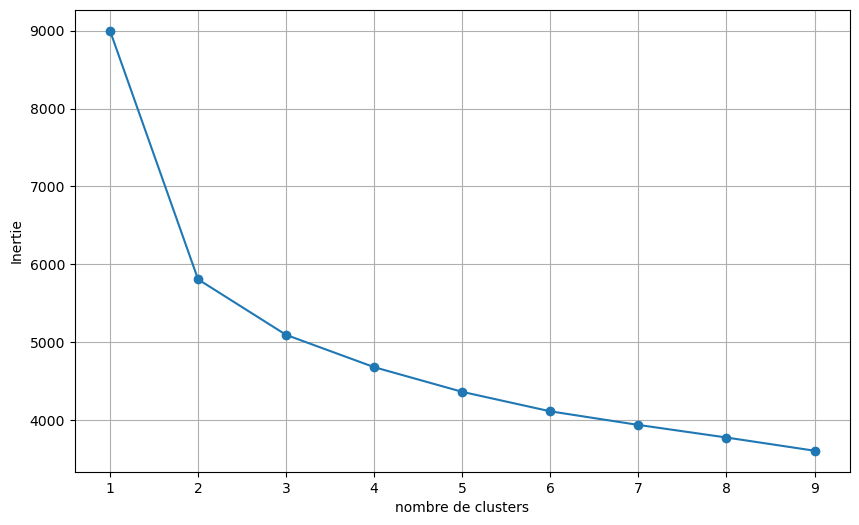

In [77]:
inertia = []
k_range=range(1,10)
for k in k_range:
    model_km = KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(model_km.inertia_)
   
fig = plt.figure(figsize=(10,6))
plt.plot(k_range,inertia, marker='o' )
plt.xlabel('nombre de clusters')
plt.ylabel('Inertie')
plt.grid() 
plt.show()

In [78]:
#Calcul  de la métrique "silhouette"
silhouettes = [] 


for k in range(2, 10): 
    clust = cluster.KMeans(n_clusters=k)  
    clust.fit(X)
    
    #Stockage des coefficients associés
    coef_sil = metrics.silhouette_score(X, clust.labels_)
    silhouettes.append(coef_sil)

C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\clust

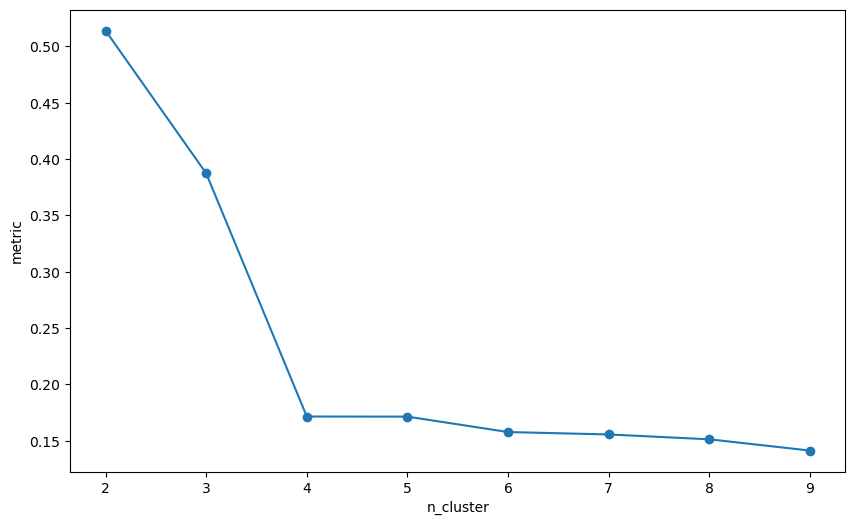

In [79]:
fig = plt.figure(figsize=(10,6))

plt.ylabel("metric")
plt.xlabel("n_cluster")

plt.plot(range(2,10), silhouettes, marker='o')
plt.show()

In [80]:
#On fit et on transforme
model_km = KMeans(n_clusters=2).fit(X_scaled)
X_test_scaled = std_scale.transform(X_test)
y_pred2 = model_km.predict(X_test_scaled)

C:\Users\clara\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\clara\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [81]:
y_pred2 = [0 if i==1 else 1 for i in y_pred2]

Text(0.5, 1.0, 'Matrice de confusion du K-means')

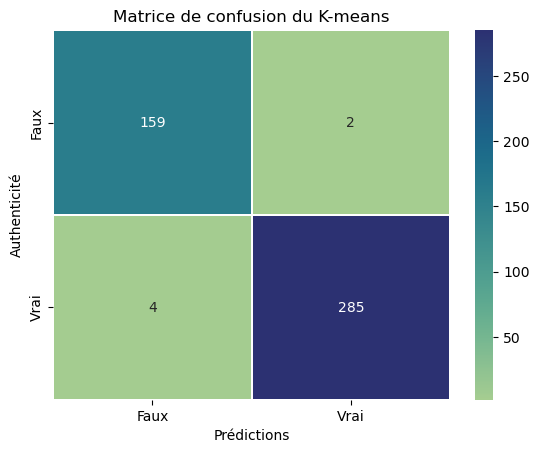

In [82]:
# Matrice de confusion
conf_matrix = metrics.confusion_matrix(y_test, y_pred2)
conf_matrix = pd.DataFrame(conf_matrix)

sns.heatmap(conf_matrix,
            annot = True,
            fmt = ".3g", 
            cmap = sns.color_palette("crest", as_cmap=True),
            linecolor = "white",
            linewidths = 0.3,
            xticklabels = ["Faux","Vrai"],
            yticklabels=["Faux","Vrai"]
            )
plt.xlabel("Prédictions")
plt.ylabel("Authenticité")
plt.title("Matrice de confusion du K-means")

In [83]:
# Composition de la matrice de confusion
vrai_pos1 = conf_matrix[1][1]
vrai_neg1 = conf_matrix[0][0]
faux_pos1 = conf_matrix[1][0]
faux_neg1 = conf_matrix[0][1]
vrai_pos1, vrai_neg1, faux_pos1, faux_neg1

(285, 159, 2, 4)

In [84]:
# Sensibilité du K-Means
sensib = vrai_pos1 / ((vrai_pos1) + faux_neg1)
sensib

0.986159169550173

In [85]:
# Spécificité du K-Means
specif = vrai_neg1 / (vrai_neg1 + faux_pos1)
specif

0.9875776397515528

In [86]:
false_positive_rate1, true_positive_rate1, thresholds = roc_curve(y_test, y_pred2)
roc_auc1 = auc(false_positive_rate1, true_positive_rate1)
print(roc_auc1)

0.9868684046508629


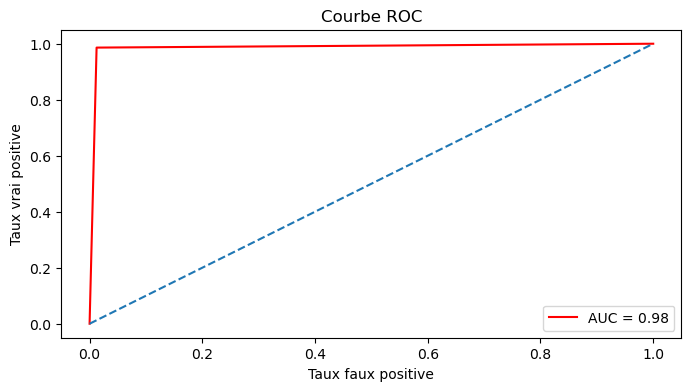

In [87]:
#Courbe Receiver Operating Characteristic (Area Under the roC) (fonction d'efficacité du recepteur)
plt.figure(figsize=(8,4))
plt.title('Courbe ROC')
plt.plot(false_positive_rate1, true_positive_rate1, color='red', label= 'AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--')
plt.axis('tight')
plt.ylabel('Taux vrai positive')
plt.xlabel('Taux faux positive')
plt.show()

In [88]:
import numpy as np
from sklearn.metrics import f1_score

f1_score = f1_score(y_test, y_pred2, average='macro')
f1_score

0.9855324074074074

In [89]:
# Accuracy score
def score(model_km):
    """compute and print train score and test score"""
    test_score = estim.score(X_test_scaled,y_pred2).round(4)
    print(f" score test: {test_score}")

In [90]:
test_score = estim.score(X_test_scaled,y_pred2).round(4)
test_score

C:\Users\clara\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


0.9756

<h3> Conclusion </h3>

Explication des différentes métriques : 

-  **Accuracy score** => Score de précision. Métrique utilisée pour évaluer la performance des modèles de classification :

            (Vrai Positif + Vrai Négatif) / Total

- **F1_Score** => Métrique d'évaluation qui combineà la fois la précision et le rappel d'un modèles en une seule valeur : 

            2x(précision X rappel) / (précision x rappel)

- **Spécificité** => Métrique qui mesure la capacité du modèle à identifier correctement les billets négatifs, un ratio entre le nb de vrai négatifs prédits et le nb total de négatifs. 
            
            Vrai Négatif / (Vrai Négatif + Faux Positif)
          
- **Sensibilité** => Métrique qui mesure la capacité du modèle à identifier correctement les billets positifs, un ratio entre le nb de vrai positifs prédits et lt nb total de positifs.

            Vrai Positif / (Vrai Positif + Faux Négatif )


In [91]:
print("Résumé des résultats de test pour la Régression Logistique :")
print( )
print("La matrice de confusion est:")
print(cm)
print( )
print("L'Accuracy score est de :", te_score)
print("Le score de notre model sur les données Test est de :", score_f1,"%")
print("La spécificité est de:", speci.round(4))
print("La sensibilité est de:", sensi.round(4))
print("Le Auc-Roc est de:", roc_auc.round(4))

Résumé des résultats de test pour la Régression Logistique :

La matrice de confusion est:
[[156   5]
 [  1 288]]

L'Accuracy score est de : 0.9867
Le score de notre model sur les données Test est de : 98.9691 %
La spécificité est de: 0.9936
La sensibilité est de: 0.9829
Le Auc-Roc est de: 0.9827


In [92]:
print("Résumé des résultats de test pour la méthode K-Means :")
print( )
print("La matrice de confusion est:")
print(conf_matrix)
print( )
print("L'Accuracy score est de :", test_score)
print("Le score de notre model sur les données Test est de :",f1_score.round(4),"%")
print("La spécificité est de:", specif.round(4))
print("La sensibilité est de:", sensib.round(4))
print("Le Auc-Roc est de:", roc_auc1.round(4))

Résumé des résultats de test pour la méthode K-Means :

La matrice de confusion est:
     0    1
0  159    2
1    4  285

L'Accuracy score est de : 0.9756
Le score de notre model sur les données Test est de : 0.9855 %
La spécificité est de: 0.9876
La sensibilité est de: 0.9862
Le Auc-Roc est de: 0.9869


Le modèle de Régression Logistique est plus performant que le modèle K-Means.

<h3> Application du modèle </h3>

In [96]:
# Importer le dataset
data = pd.read_csv('billets_production.csv', sep=',')
data

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [62]:
# Séparer les données
X = data[['diagonal','height_left','height_right','margin_low','margin_up','length']]
y = data['id']

In [65]:
# Application du modèle predict
y_pred = estim.predict(X)
y_pred

array([0, 0, 0, 1, 1], dtype=int64)

In [93]:
data1 = data.copy()
data1

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [94]:
data1['y_pred'] = y_pred
data1

,diagonal,height_left,height_right,margin_low,margin_up,length,id,y_pred
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1
